In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, ReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
import tensorflow as tf
# from tensorflow import InteractiveSession
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import os
from PIL import Image
import glob
from os import listdir
from os.path import isfile, join

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('test_assignment_sim.csv')
df

,FLOWFACTOR,SPACING,DEP TIME,TOOL,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,...,SITE_39,SITE_40,SITE_41,SITE_42,SITE_43,SITE_44,SITE_45,SITE_46,SITE_47,SITE_48
0,0.916,0.344,69.289,1,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,...,1593.296029,1592.948758,1592.601486,1592.254216,1591.906946,1591.559675,1591.212405,1590.865134,1590.517862,1590.170593
1,0.916,0.344,69.289,2,1516.411140,1495.080373,1516.482818,1516.366352,1516.918855,1514.835611,...,1481.353478,1481.157584,1480.961690,1480.765797,1480.906328,1481.052943,1480.847698,1480.888354,1481.306459,1481.724561
2,0.916,0.344,69.289,3,1478.098433,1457.372553,1483.945610,1481.342541,1475.516841,1472.935249,...,1491.287428,1490.630367,1489.973305,1489.130805,1487.315196,1485.659583,1484.266940,1482.874286,1481.481632,1480.088988
3,0.916,0.344,69.289,4,1550.290615,1529.621080,1548.352252,1549.929704,1549.697136,1549.235110,...,1508.932376,1508.732902,1508.347436,1508.052235,1508.214925,1508.596579,1509.101775,1509.606975,1510.373006,1511.108004
4,0.957,0.348,70.253,1,1544.883218,1495.156181,1549.023309,1547.829132,1544.253208,1543.623198,...,1569.233533,1569.257056,1569.280579,1569.252501,1568.966865,1568.681228,1568.395593,1567.875699,1567.033903,1565.635512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.910,0.348,71.494,4,1579.678027,1554.131399,1582.133349,1581.752614,1578.538616,1576.167197,...,1591.884877,1593.910444,1595.920244,1597.930029,1599.939823,1601.064937,1602.044671,1602.274183,1602.330867,1602.387550
496,0.923,0.355,67.191,1,1506.290611,1444.277495,1505.734563,1505.713624,1506.867599,1507.444587,...,1485.450492,1484.933765,1484.315053,1483.920045,1483.788719,1483.811746,1484.540330,1485.410265,1486.280199,1487.150128
497,0.923,0.355,67.191,2,1433.885814,1401.300015,1441.602347,1437.744081,1430.923555,1428.490734,...,1390.019767,1389.793481,1389.567195,1389.669224,1389.903776,1390.894207,1390.904922,1391.148082,1392.018843,1392.553429
498,0.923,0.355,67.191,3,1385.057129,1355.168231,1387.311600,1384.319977,1384.609278,1382.555992,...,1358.969083,1357.977233,1356.985383,1355.993540,1355.001693,1354.009846,1353.018003,1352.026153,1351.034303,1350.042460


In [4]:
all_sites = ['SITE_0', 'SITE_1',
       'SITE_2', 'SITE_3', 'SITE_4', 'SITE_5', 'SITE_6', 'SITE_7', 'SITE_8',
       'SITE_9', 'SITE_10', 'SITE_11', 'SITE_12', 'SITE_13', 'SITE_14',
       'SITE_15', 'SITE_16', 'SITE_17', 'SITE_18', 'SITE_19', 'SITE_20',
       'SITE_21', 'SITE_22', 'SITE_23', 'SITE_24', 'SITE_25', 'SITE_26',
       'SITE_27', 'SITE_28', 'SITE_29', 'SITE_30', 'SITE_31', 'SITE_32',
       'SITE_33', 'SITE_34', 'SITE_35', 'SITE_36', 'SITE_37', 'SITE_38',
       'SITE_39', 'SITE_40', 'SITE_41', 'SITE_42', 'SITE_43', 'SITE_44',
       'SITE_45', 'SITE_46', 'SITE_47', 'SITE_48']

Transforming feature columns to labels for GAN:

In [5]:
Y_COLUMNS = ['FLOWFACTOR', 'SPACING', 'DEP TIME']
scaler_y = MinMaxScaler()

y = df[Y_COLUMNS]
y_scaled = scaler_y.fit_transform(y)

tsne=TSNE()
y_tsne = tsne.fit_transform(y_scaled)

FLOWFACTOR


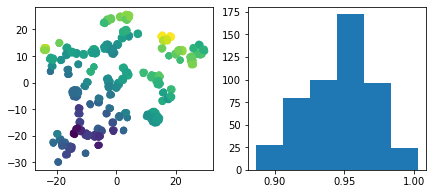

SPACING


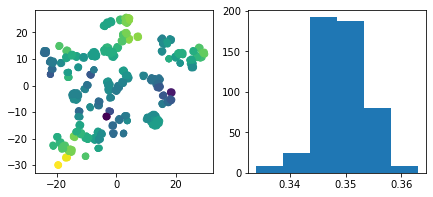

DEP TIME


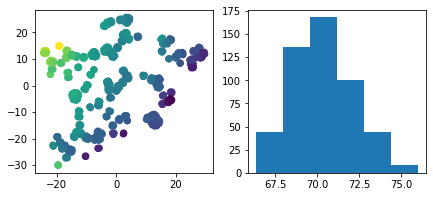

In [6]:
#number of bins per each extrinsic properties
BINS=6

for Y_column in Y_COLUMNS:
    print(Y_column)
    fig, axs= plt.subplots(1,2, figsize=(7,3))
    im=axs[0].scatter(y_tsne[:,0], y_tsne[:,1], c= df[Y_column]);
    h=axs[1].hist(df[Y_column], bins=BINS)
    plt.show()

binning_labels_dict={}
binning_labels_dict['TOOL_binning'] = df['TOOL'].values

Y_COLUMNS_BINNING=['TOOL_binning']
for Y_column in Y_COLUMNS:
    cnt, bins = np.histogram(df[Y_column], bins=BINS)
    bins[0] -= 1
    col_name = Y_column + "_binning"
    binning_labels_dict[col_name] = np.searchsorted(bins, df[Y_column].values)
    Y_COLUMNS_BINNING.append(col_name)
    

In [7]:
binning_df = pd.DataFrame(binning_labels_dict)#.groupby(col_name).count()
binning_df["T"] = 1
count_bins_df = binning_df.groupby(Y_COLUMNS_BINNING).count()
max_count = count_bins_df["T"].max()

df = pd.concat((df,binning_df),axis=1)
df = df.drop("T",axis=1)
count_bins_df = count_bins_df.reset_index()
df = pd.merge(df,count_bins_df,on=Y_COLUMNS_BINNING)
df["weight"] = max_count/df["T"]

In [8]:
df = pd.get_dummies(df, columns=['TOOL'] )

In [9]:
df

,FLOWFACTOR,SPACING,DEP TIME,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,SITE_6,...,TOOL_binning,FLOWFACTOR_binning,SPACING_binning,DEP TIME_binning,T,weight,TOOL_1,TOOL_2,TOOL_3,TOOL_4
0,0.916,0.344,69.289,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,1592.004563,...,1,2,3,2,2,3.0,1,0,0,0
1,0.916,0.348,69.402,1586.827374,1536.578580,1587.316760,1587.107206,1587.430629,1590.104267,1587.945422,...,1,2,3,2,2,3.0,1,0,0,0
2,0.916,0.344,69.289,1516.411140,1495.080373,1516.482818,1516.366352,1516.918855,1514.835611,1503.485462,...,2,2,3,2,2,3.0,0,1,0,0
3,0.916,0.348,69.402,1522.882735,1486.027159,1519.176109,1521.633342,1524.163318,1521.685239,1515.835756,...,2,2,3,2,2,3.0,0,1,0,0
4,0.916,0.344,69.289,1478.098433,1457.372553,1483.945610,1481.342541,1475.516841,1472.935249,1490.164818,...,3,2,3,2,2,3.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.953,0.352,73.086,1514.031349,1498.937449,1517.687851,1515.859600,1514.550610,1518.317762,1519.560080,...,4,4,4,5,1,6.0,0,0,0,1
496,0.923,0.355,67.191,1506.290611,1444.277495,1505.734563,1505.713624,1506.867599,1507.444587,1507.236026,...,1,2,5,1,1,6.0,1,0,0,0
497,0.923,0.355,67.191,1433.885814,1401.300015,1441.602347,1437.744081,1430.923555,1428.490734,1442.051871,...,2,2,5,1,1,6.0,0,1,0,0
498,0.923,0.355,67.191,1385.057129,1355.168231,1387.311600,1384.319977,1384.609278,1382.555992,1397.128710,...,3,2,5,1,1,6.0,0,0,1,0


In [10]:
Y_COLUMNS = ['FLOWFACTOR', 'SPACING', 'DEP TIME', 'TOOL_1', 'TOOL_2', 'TOOL_3', 'TOOL_4']

In [11]:
df

,FLOWFACTOR,SPACING,DEP TIME,SITE_0,SITE_1,SITE_2,SITE_3,SITE_4,SITE_5,SITE_6,...,TOOL_binning,FLOWFACTOR_binning,SPACING_binning,DEP TIME_binning,T,weight,TOOL_1,TOOL_2,TOOL_3,TOOL_4
0,0.916,0.344,69.289,1601.802686,1556.668725,1597.900238,1599.790647,1601.083756,1601.116007,1592.004563,...,1,2,3,2,2,3.0,1,0,0,0
1,0.916,0.348,69.402,1586.827374,1536.578580,1587.316760,1587.107206,1587.430629,1590.104267,1587.945422,...,1,2,3,2,2,3.0,1,0,0,0
2,0.916,0.344,69.289,1516.411140,1495.080373,1516.482818,1516.366352,1516.918855,1514.835611,1503.485462,...,2,2,3,2,2,3.0,0,1,0,0
3,0.916,0.348,69.402,1522.882735,1486.027159,1519.176109,1521.633342,1524.163318,1521.685239,1515.835756,...,2,2,3,2,2,3.0,0,1,0,0
4,0.916,0.344,69.289,1478.098433,1457.372553,1483.945610,1481.342541,1475.516841,1472.935249,1490.164818,...,3,2,3,2,2,3.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.953,0.352,73.086,1514.031349,1498.937449,1517.687851,1515.859600,1514.550610,1518.317762,1519.560080,...,4,4,4,5,1,6.0,0,0,0,1
496,0.923,0.355,67.191,1506.290611,1444.277495,1505.734563,1505.713624,1506.867599,1507.444587,1507.236026,...,1,2,5,1,1,6.0,1,0,0,0
497,0.923,0.355,67.191,1433.885814,1401.300015,1441.602347,1437.744081,1430.923555,1428.490734,1442.051871,...,2,2,5,1,1,6.0,0,1,0,0
498,0.923,0.355,67.191,1385.057129,1355.168231,1387.311600,1384.319977,1384.609278,1382.555992,1397.128710,...,3,2,5,1,1,6.0,0,0,1,0


In [21]:
XS_scaled = XS_scaled.reshape(500, 7, 7)

array([[0.75193346, 0.7036996 , 0.74503645, 0.74806479, 0.73390715,
        0.72884999, 0.74553252],
       [0.74578887, 0.75775959, 0.66256934, 0.65790002, 0.65877489,
        0.6731315 , 0.68203632],
       [0.68289566, 0.68375096, 0.69121534, 0.70160332, 0.63748718,
        0.64543297, 0.64248204],
       [0.64211322, 0.64077519, 0.65302321, 0.65975942, 0.53385198,
        0.52633706, 0.51638047],
       [0.50235203, 0.49012016, 0.48472646, 0.4820043 , 0.48281059,
        0.48579978, 0.49351085],
       [0.5055198 , 0.51485341, 0.52350064, 0.59846304, 0.59503532,
        0.58756778, 0.58014385],
       [0.57281379, 0.56739313, 0.56120713, 0.55653415, 0.55185919,
        0.54718228, 0.54132545]])

In [22]:
BATCH_SIZE=16
batch_count = int(np.ceil(len(df)/BATCH_SIZE))

YS = []
WEIGHTS=[]

for b in range(0, batch_count):
    print(b * BATCH_SIZE,"->",min(len(df), b * BATCH_SIZE+BATCH_SIZE) - 1)
    batch_indices = np.arange(b * BATCH_SIZE, min(len(df), b * BATCH_SIZE + BATCH_SIZE))
    for ind in batch_indices:              
        YS.append(df.loc[ind,Y_COLUMNS].values)
        WEIGHTS.append(df.loc[ind,"weight"])
        
YS = np.array(YS)
WEIGHTS = np.array(WEIGHTS)
XS_scaled = XS_scaled.reshape(500, 7, 7)

scaler_y_2 = MinMaxScaler()
YS_scaled = scaler_y_2.fit_transform(YS)
dataset=(XS_scaled, YS_scaled, WEIGHTS)

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 127
128 -> 143
144 -> 159
160 -> 175
176 -> 191
192 -> 207
208 -> 223
224 -> 239
240 -> 255
256 -> 271
272 -> 287
288 -> 303
304 -> 319
320 -> 335
336 -> 351
352 -> 367
368 -> 383
384 -> 399
400 -> 415
416 -> 431
432 -> 447
448 -> 463
464 -> 479
480 -> 495
496 -> 499


In [23]:
INPUT_SHAPE=(7, 7, 1)
EXTRINSIC_DIM = 7 #LABELS, Y
latent_dim = 32 # need to confirm
LATENT_DIM = latent_dim

## Discriminator Model

In [66]:
# define the standalone discriminator model
# @tf.function
def define_cond_discriminator(in_shape=INPUT_SHAPE, n_classes=EXTRINSIC_DIM):    
    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]

    li = Dense(n_nodes)(in_label)

    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # image input
    in_image = Input(shape=in_shape, name="X")
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
#     fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
#     fe = Dropout(0.3)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
#     fe = BatchNormalization()(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid',name="Discriminator")(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.00001, beta_1=0.5)
    #opt = Adadelta()

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [67]:
discriminator_model = define_cond_discriminator()

In [68]:
discriminator_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Y_extrinsic (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 49)           392         Y_extrinsic[0][0]                
__________________________________________________________________________________________________
X (InputLayer)                  [(None, 7, 7, 1)]    0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 7, 7, 1)      0           dense_3[0][0]                    
_______________________________________________________________________________________

## Generator Model

In [69]:

# define the standalone generator model
def define_cond_generator(latent_dim=LATENT_DIM, n_classes=EXTRINSIC_DIM):
    init_size=(7, 7)

    # label input
    in_label = Input(shape=(EXTRINSIC_DIM,), name="Y_extrinsic")
    # linear multiplication
    n_nodes = init_size[0] * init_size[1]
    li = Dense(n_nodes)(in_label)
    li = BatchNormalization()(li)
    li = Dropout(0.3)(li)

    # reshape to additional channel
    li = Reshape((init_size[0] , init_size[1], 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,), name="Z_latent")
    # foundation for 7x7 image
    n_nodes = 128 * n_nodes
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization()(gen)
    gen = Dropout(0.5)(gen)
    
    gen = Reshape((init_size[0], init_size[1], 128))(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])
   
#     gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(merge)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
#     gen = Dropout(0.2)(gen)

#     gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
#     gen = Dropout(0.2)(gen)
    
#     gen = Conv2D(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = BatchNormalization()(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
# #     fe = Dropout(0.3)(fe)
#     # downsample
#     gen = Conv2D(128, (3,3), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)
    
#     gen = Reshape((5, 10, 1))(gen)

    # output
    out_layer = Conv2D(1, (7, 7),activation='tanh', padding='same', name="X_generated")(merge)

    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [70]:
generator_model = define_cond_generator()

    

In [71]:
generator_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Z_latent (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         206976      Z_latent[0][0]                   
__________________________________________________________________________________________________
Y_extrinsic (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 6272)         0           dense_5[0][0]                    
_______________________________________________________________________________________

## Combine generator and discriminator model

In [72]:
# define the combined generator and discriminator model, for updating the generator
def define_cond_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.00001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [73]:
GAN = define_cond_gan(generator_model, discriminator_model)

# Generate Real and Fake Samples:

In [74]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into vector and labels
    vector, labels, weights = dataset
    # choose random instances
    ix = np.random.randint(0, vector.shape[0]-1, n_samples) # n_samples were removed I dunno why
    # select vector and labels
    X, labels, weights = vector[ix], labels[ix], weights[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y, weights

In [75]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=EXTRINSIC_DIM):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(len(YS), size=n_samples)
    weights = WEIGHTS[labels]
    labels= YS_scaled[labels]    
    return z_input, labels, weights

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, weights_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y, weights_input

In [76]:
 z_input, labels_input, weights_input = generate_latent_points(latent_dim, 16)

In [64]:
# function for trainining of generator and discriminator
def train_cgan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=32, verbose_freq=10, n_batch=32):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    d_loss1_epochs=[]
    d_loss2_epochs=[]
    g_loss_epochs=[]
    d_loss1_batch=[]
    d_loss2_batch=[]
    g_loss_batch=[]
    
    
    # manually enumerate epochs
    iteration=0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real, weights_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real,) # sample_weight=weights_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake, weights_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake,)#sample_weight=weights_fake)
            # prepare points in latent space as input for the generator
            z_input, labels_input, weights_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan,) #sample_weight=weights_gan)
            
            d_loss1_batch.append(d_loss1)
            d_loss2_batch.append(d_loss2)
            g_loss_batch.append(g_loss)
        

            # visualizing the training steps
            if (iteration%verbose_freq==0):
                if ax.lines:
                    epochs_x = (np.arange(len(d_loss2_batch))+1)/bat_per_epo
                    for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
                        line.set_xdata(epochs_x)
                        line.set_ydata(ydata) 
                    ax.set_xlim(0,max(epochs_x) + 1/bat_per_epo)
                    ax.set_ylim(0.9 * min([min(d_loss1_batch), min(d_loss2_batch), min(g_loss_batch)]), 1.1 * max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
                else:
                    ax.plot(d_loss1_batch, label="d_loss_real")
                    ax.plot(d_loss2_batch, label="d_loss_fake")
                    ax.plot(g_loss_batch, label="g_loss")                 
                    fig.legend()
                fig.canvas.draw()
                
            iteration += 1
            
    if ax.lines:        
        epochs_x=(np.arange(len(d_loss2_batch))+1)/bat_per_epo
        for line,ydata in zip(ax.lines,[d_loss1_batch, d_loss2_batch,g_loss_batch]):
            line.set_xdata(epochs_x)
            line.set_ydata(ydata) 
        ax.set_xlim(0,max(epochs_x)+1/bat_per_epo)
        ax.set_ylim(0.9*min([min(d_loss1_batch),min(d_loss2_batch),min(g_loss_batch)]),1.1*max([max(d_loss1_batch), max(d_loss2_batch), max(g_loss_batch)]))
    else:
        ax.plot(d_loss1_batch, label="d_loss_real")
        ax.plot(d_loss2_batch, label="d_loss_fake")
        ax.plot(g_loss_batch, label="g_loss")                 
        fig.legend()
    fig.canvas.draw()

train model for 1024
0
62.5


<IPython.core.display.Javascript object>


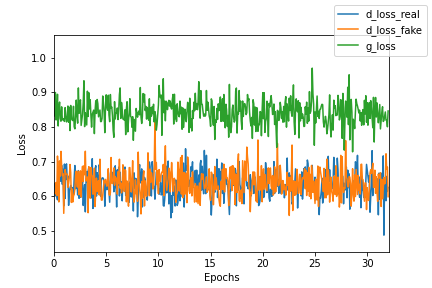

1
125.0


<IPython.core.display.Javascript object>


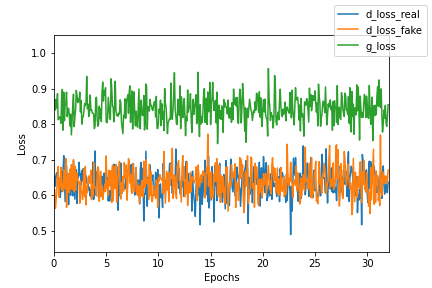

2
187.5


<IPython.core.display.Javascript object>


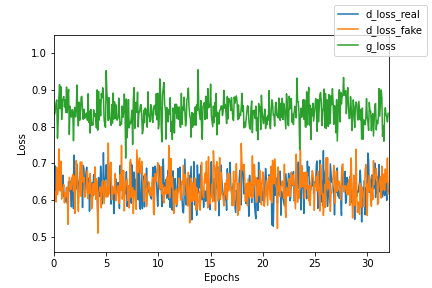

3
250.0


<IPython.core.display.Javascript object>


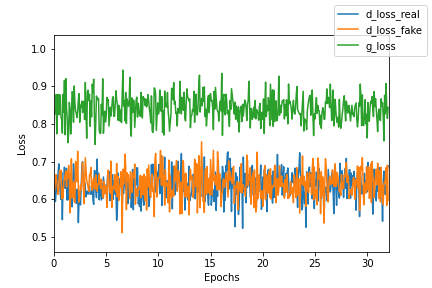

4
312.5


<IPython.core.display.Javascript object>


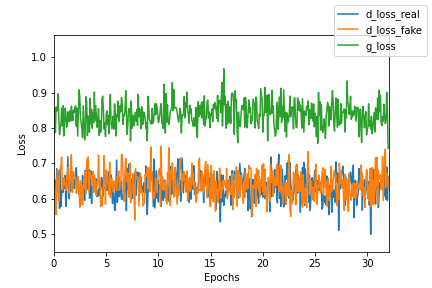

5
375.0


<IPython.core.display.Javascript object>


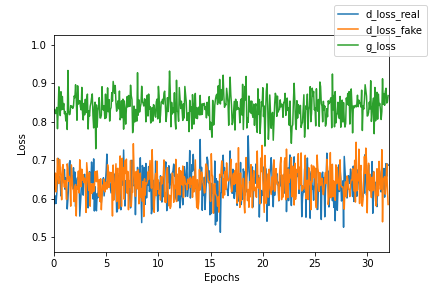

6
437.5


<IPython.core.display.Javascript object>


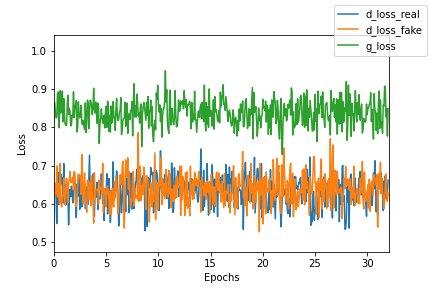

7
500.0


<IPython.core.display.Javascript object>


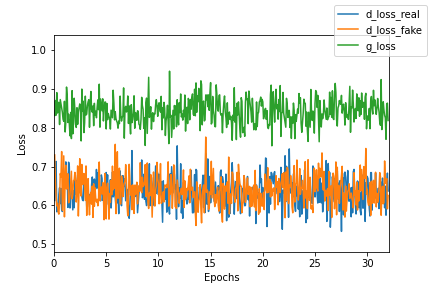

8
562.5


<IPython.core.display.Javascript object>


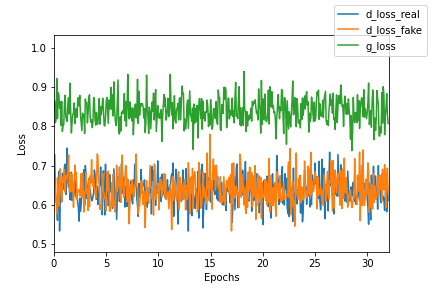

9
625.0


<IPython.core.display.Javascript object>


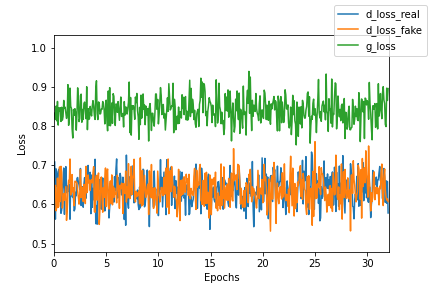

10
687.5


<IPython.core.display.Javascript object>


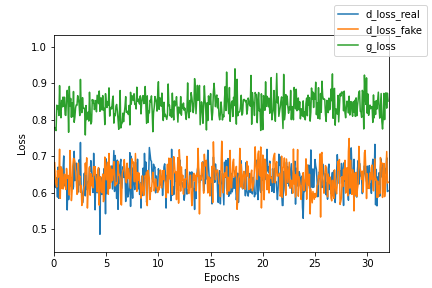

11
750.0


<IPython.core.display.Javascript object>


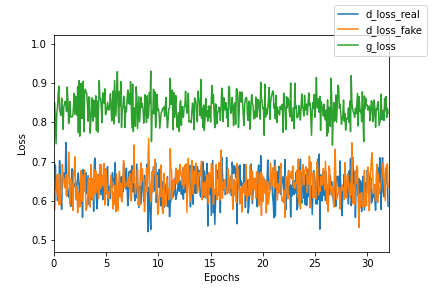

12
812.5


<IPython.core.display.Javascript object>


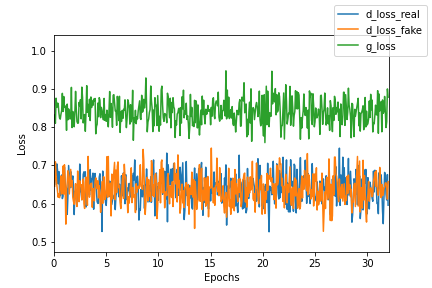

13
875.0


<IPython.core.display.Javascript object>


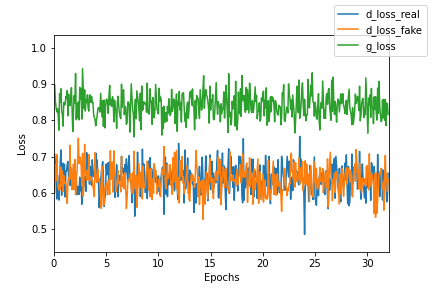

14
937.5


<IPython.core.display.Javascript object>


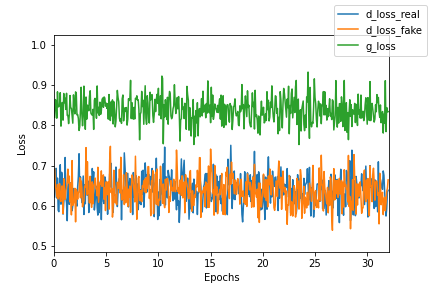

15
1000.0


<IPython.core.display.Javascript object>


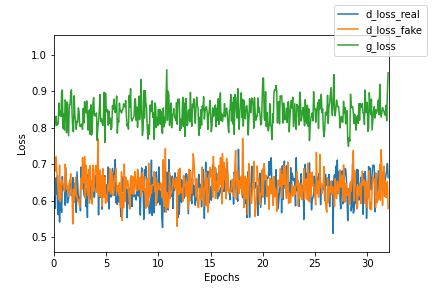

16
1062.5


<IPython.core.display.Javascript object>


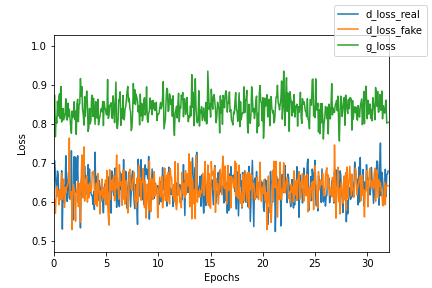

17
1125.0


<IPython.core.display.Javascript object>


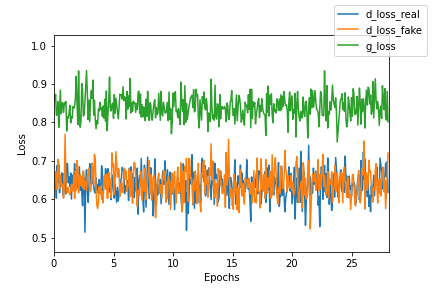

In [ ]:
%matplotlib notebook
# train model
n_runs = 64
total_batch = 0
total_epochs = 0
n_batch = 128
n_epochs = 16

print('train model for ' + str(n_runs * n_epochs))
for k in range(n_runs):
    print(k)
    total_batch = total_batch + (dataset[0].shape[0] / n_batch) * n_epochs
    print(total_batch)
    train_cgan(generator_model, discriminator_model, GAN, dataset, latent_dim)
    pp = create_process_vector(YS[0])
    latent_points, labels, _ = generate_latent_points(latent_dim, 1)
    del labels
    X_test = generator_model.predict([latent_points, pp])
    X_test = scaler_x.inverse_transform(X_test.reshape(1,-1))
    visualize(X_test[0])
    

    # save models
    savename = '7x7'
    generator_model.save(savename+'_total_batches_'+str(total_batch) + '_generator.h5')
    discriminator_model.save(savename+'_total_batches_'+str(total_batch) + ' _discriminator.h5')
    GAN.save(savename+'_total_batches_'+str(total_batch) + '_gan.h5')

In [52]:
generator_model.load_weights('conv_paper_2_total_batches_62.5_generator.h5')

In [37]:
def create_process_vector(features):
    features = np.array(features).reshape(1, -1)
    process_vector = scaler_y_2.transform(features)
    return process_vector

In [38]:
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

def visualize(thickness):
    site = pd.read_csv('site_coordinates.csv')
    site['SITE_Z'] = thickness
    points2D = np.vstack([site['SITE_X'], site['SITE_Y']]).T
    tri = Delaunay(points2D)
    simplices = tri.simplices

    fig = ff.create_trisurf(site['SITE_X'], site['SITE_Y'], site['SITE_Z'],
                             simplices=simplices,
                             title="wafare", aspectratio=dict(x=1, y=1, z=0.5))
    fig.show()


In [61]:
latent_points, labels, _ = generate_latent_points(latent_dim, 1)

In [62]:
# latent_points, labels, _ = generate_latent_points(latent_dim, 1)
pp = create_process_vector(YS[33])
print(pp)
X_test = generator_model.predict([latent_points, pp])

X_test = X_test.reshape(49,)
X_test = scaler_x.inverse_transform(X_test.reshape(1,-1))
visualize(X_test[0])

[[0.68103448 0.44827586 0.44525169 0.         1.         0.
  0.        ]]


In [53]:
X_test

array([[1502.6676, 1469.3438, 1502.6155, 1492.2522, 1500.2   , 1507.66  ,
        1503.7039, 1507.5095, 1516.1707, 1527.1918, 1514.3368, 1530.0546,
        1531.8553, 1534.196 , 1536.0824, 1513.83  , 1530.313 , 1532.6694,
        1535.8965, 1522.9084, 1521.8765, 1527.1206, 1530.9148, 1539.8528,
        1511.6669, 1497.9148, 1479.6053, 1496.692 , 1501.1361, 1493.5087,
        1476.1307, 1509.6542, 1490.7192, 1480.768 , 1484.6875, 1503.5248,
        1493.87  , 1480.1549, 1479.1864, 1489.6433, 1478.2898, 1487.9697,
        1497.5548, 1492.4487, 1480.9961, 1496.6692, 1493.3058, 1488.6495,
        1493.4456]], dtype=float32)

In [50]:
X_test = X_test.reshape(49,)
X_test = scaler_x.inverse_transform(X_test.reshape(1,-1))


array([[1502.6676, 1469.3438, 1502.6155, 1492.2522, 1500.2   , 1507.66  ,
        1503.7039, 1507.5095, 1516.1707, 1527.1918, 1514.3368, 1530.0546,
        1531.8553, 1534.196 , 1536.0824, 1513.83  , 1530.313 , 1532.6694,
        1535.8965, 1522.9084, 1521.8765, 1527.1206, 1530.9148, 1539.8528,
        1511.6669, 1497.9148, 1479.6053, 1496.692 , 1501.1361, 1493.5087,
        1476.1307, 1509.6542, 1490.7192, 1480.768 , 1484.6875, 1503.5248,
        1493.87  , 1480.1549, 1479.1864, 1489.6433, 1478.2898, 1487.9697,
        1497.5548, 1492.4487, 1480.9961, 1496.6692, 1493.3058, 1488.6495,
        1493.4456]], dtype=float32)

In [40]:
latent_points, labels, _ = generate_latent_points(latent_dim, 1)

X_test = generator_model.predict([latent_points, pp])

NameError: name 'pp' is not defined

In [158]:
visualize(X_test)

In [157]:
X_test = thickness_extraction(X_test[0])

In [129]:
visualize(thickness_extraction(XS_mat[0]))

In [38]:
!pip install ipympl

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
